In [123]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [124]:
import numpy as np
from math import sqrt
from os import listdir, getcwd
from os.path import isfile, join
import scipy.io.wavfile
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import figure as fig
from IPython.display import Audio
import seaborn as sns
from tempfile import TemporaryFile
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import pandas as pd

from skimage.filters import gabor

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

In [ ]:
sampling_frequency = 44100
brachial_audio_dir = join(getcwd(),'..','vsu_tms_site','doppler_audio_samples','brachial')
brachial_wav_filenames = [f for f in listdir(brachial_audio_dir) if isfile(join(brachial_audio_dir,f)) and str(f)[-3:] not in 'txt']
brachial_wav_files = []
carotid_audio_dir = join(getcwd(),'..','vsu_tms_site','doppler_audio_samples','carotid')
carotid_wav_filenames = [f for f in listdir(carotid_audio_dir) if isfile(join(carotid_audio_dir,f)) and str(f)[-3:] not in 'txt']
carotid_wav_files = []

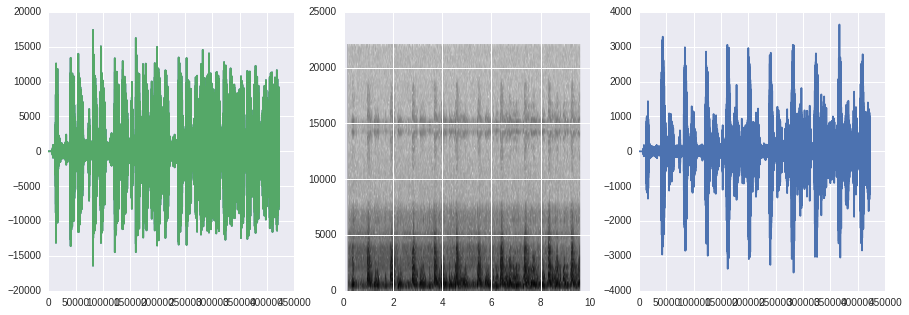

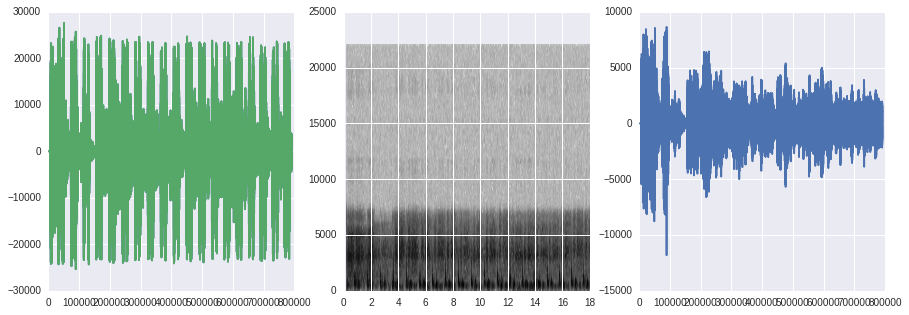

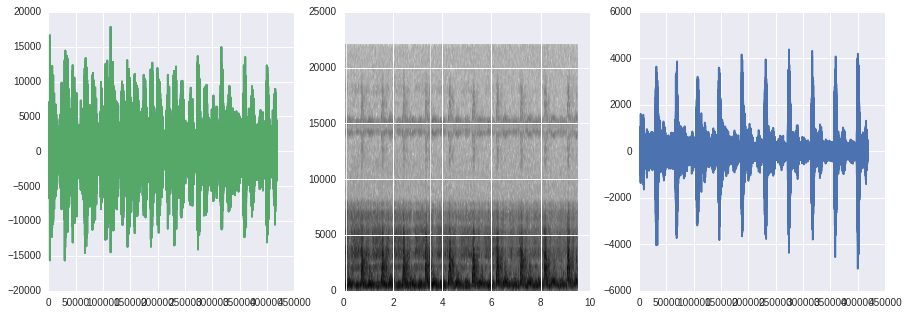

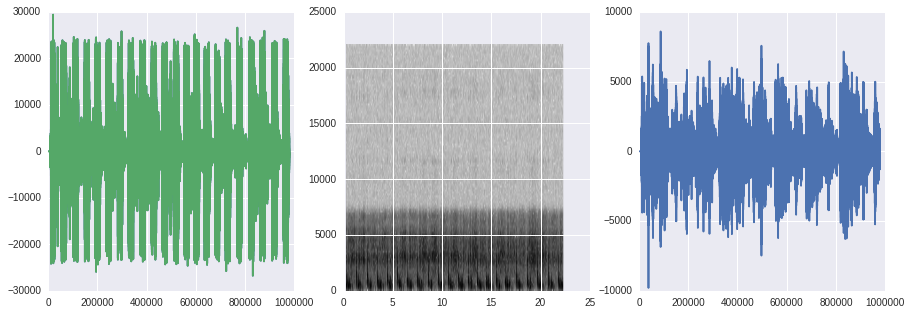

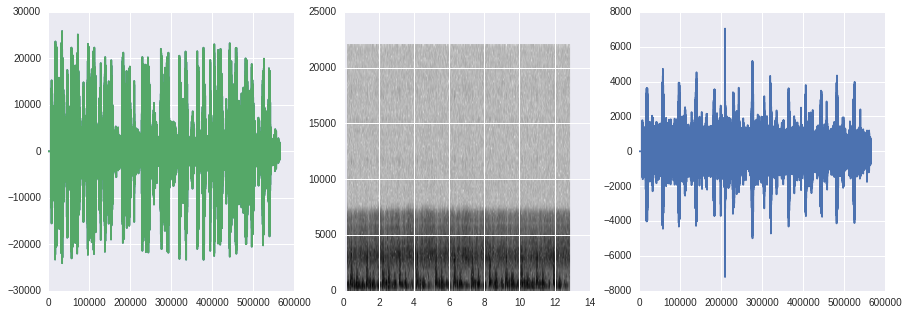

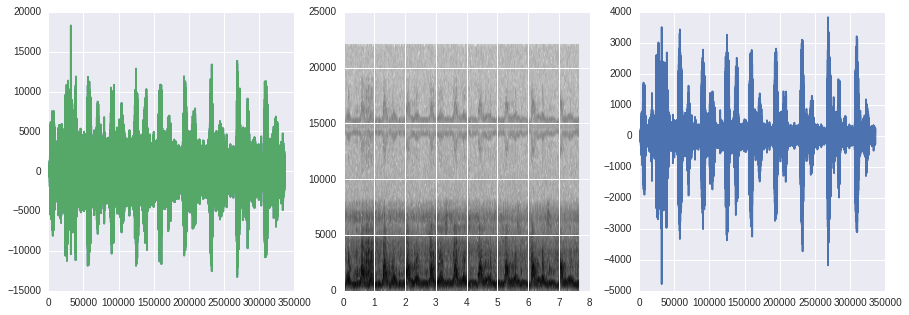

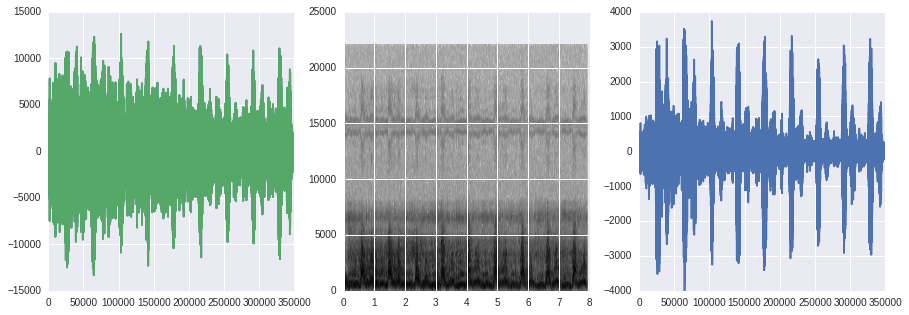

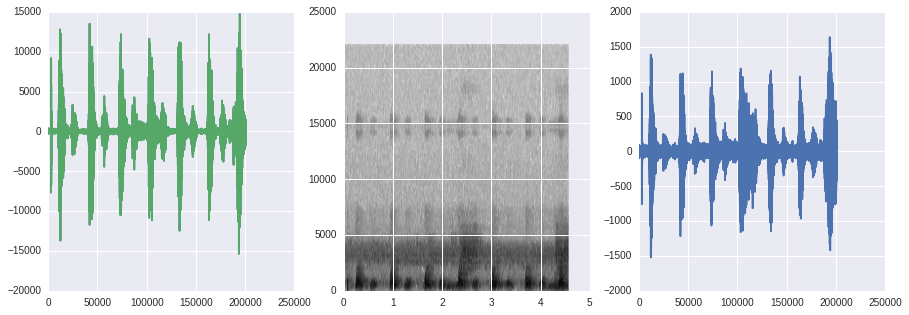

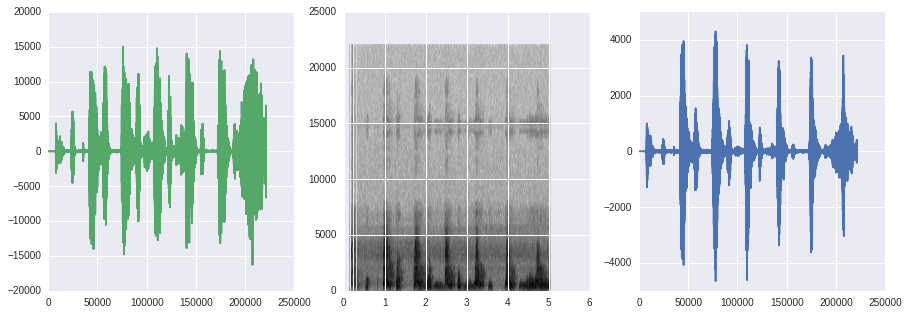

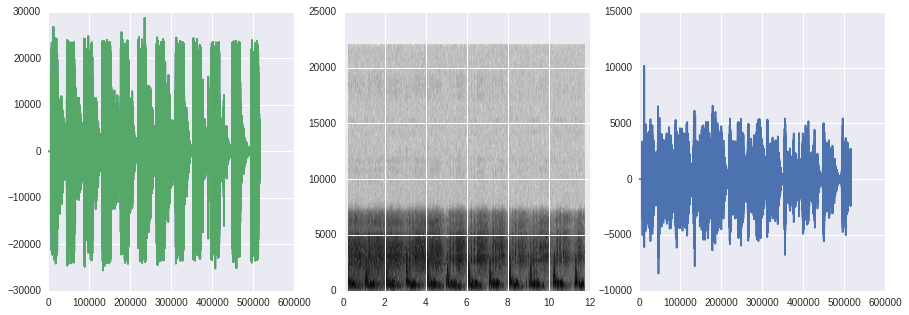

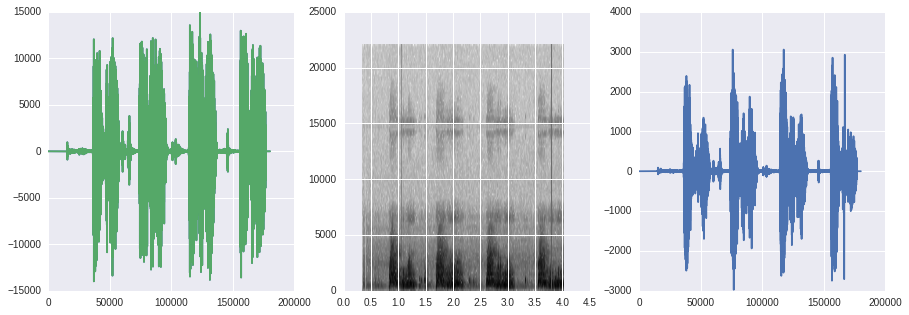

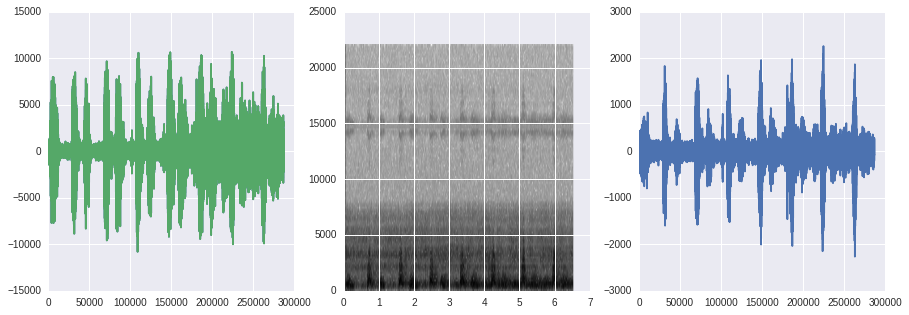

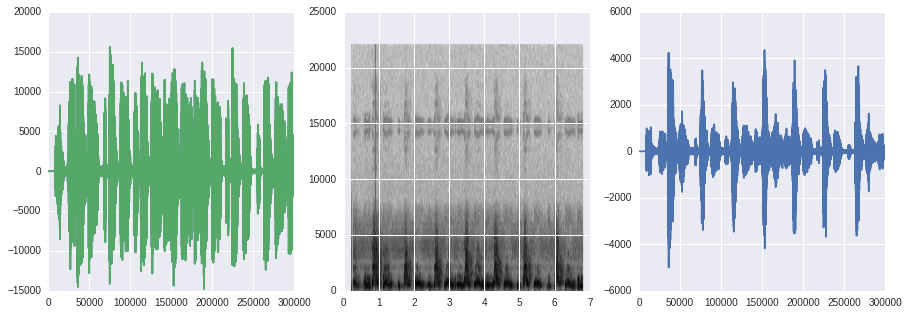

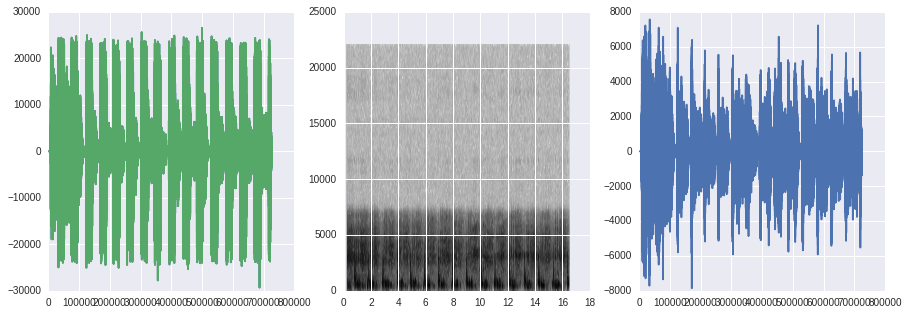

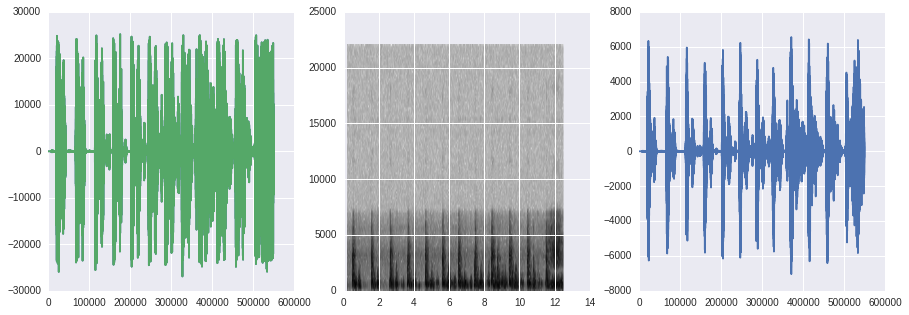

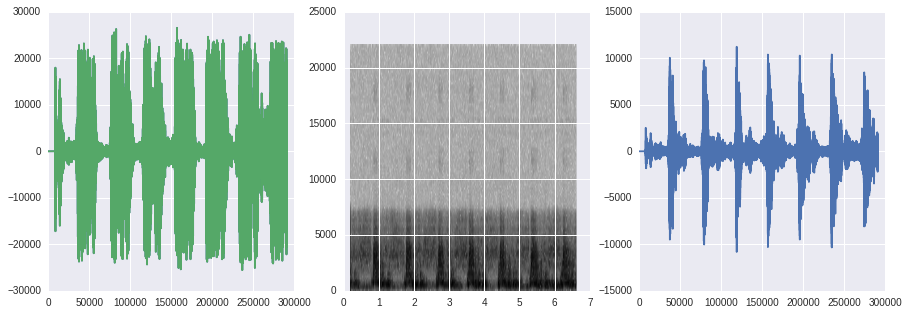

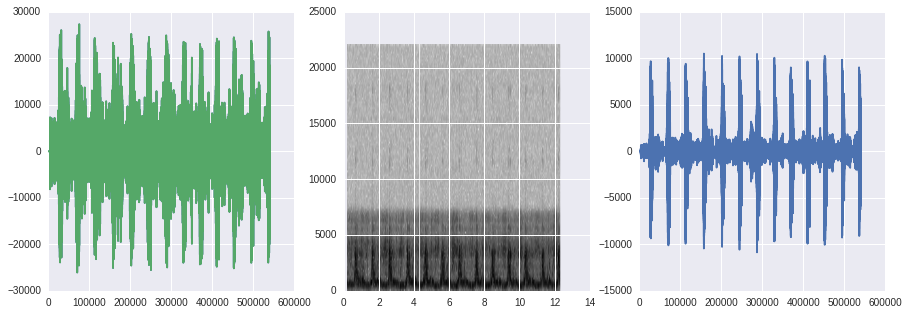

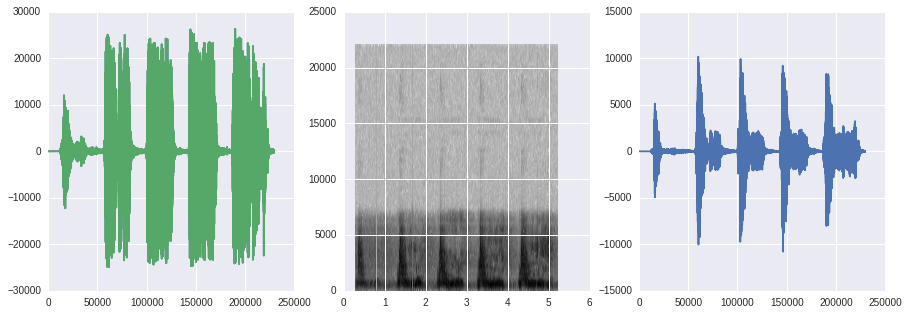

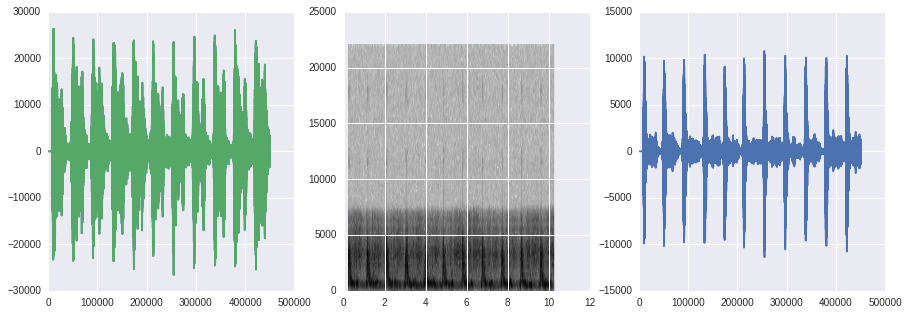

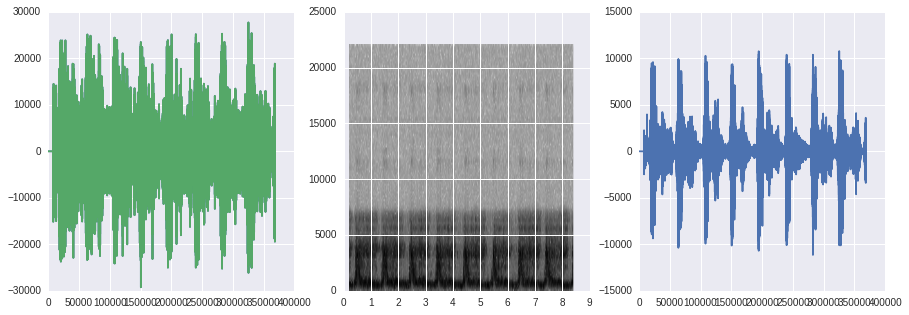

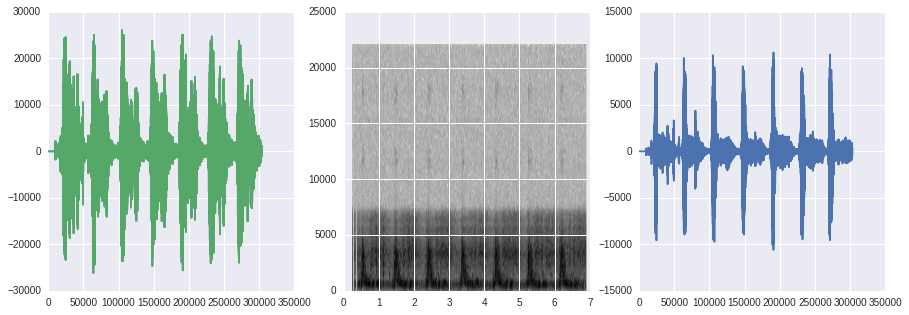

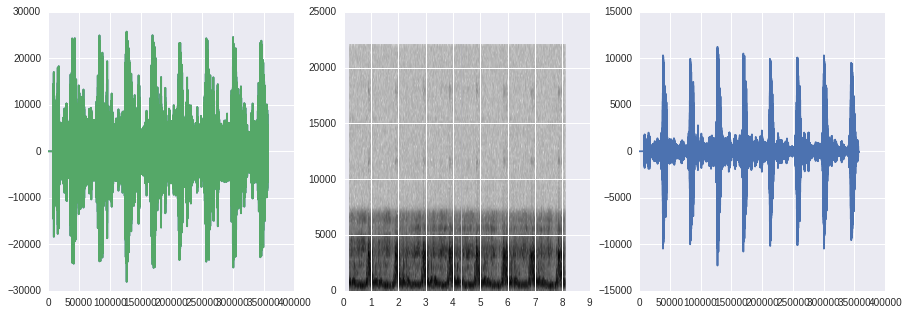

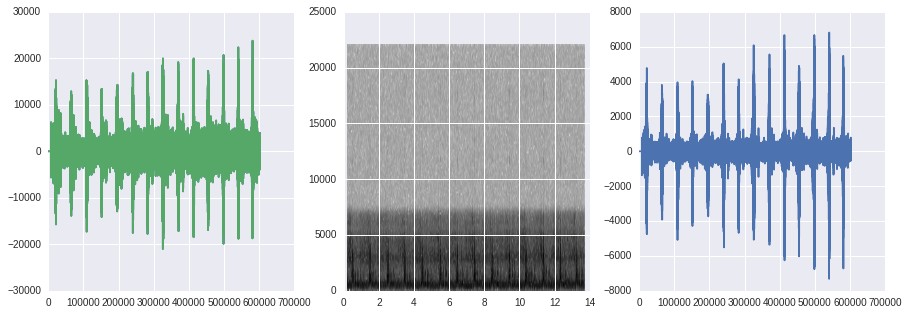

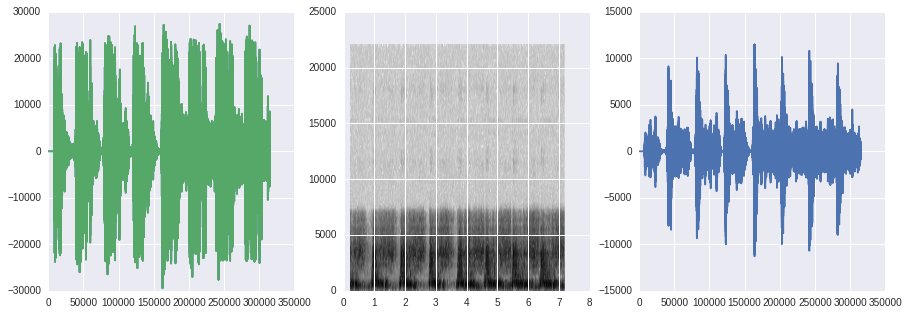

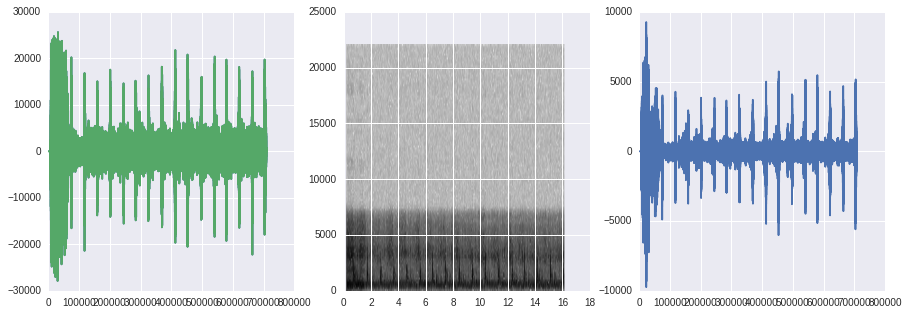

In [ ]:
for f in brachial_wav_filenames:
    rate, wf = scipy.io.wavfile.read(join(brachial_audio_dir,f))
    brachial_wav_files.append(wf)
    #xs = [i / float(sampling_frequency) for i in range(0, len(wf[:,0]))]
    f, axarr = plt.subplots(1,3,figsize=(15,5))
    axarr[0].plot(wf)
    audio_out = wf[:,0]
    data, freqs, bins, im = axarr[1].specgram(audio_out, Fs=sampling_frequency)
    axarr[2].plot(np.gradient(wf[:,0]))
    plt.show()
for f in carotid_wav_filenames:
    rate, wf = scipy.io.wavfile.read(join(carotid_audio_dir,f))
    carotid_wav_files.append(wf)
    #xs = [i / float(sampling_frequency) for i in range(0, len(wf[:,0]))]
    f, axarr = plt.subplots(1,3,figsize=(15,5))
    axarr[0].plot(wf)
    audio_out = wf[:,0]
    data, freqs, bins, im = axarr[1].specgram(audio_out, Fs=sampling_frequency)
    axarr[2].plot(np.gradient(wf[:,0]))
    plt.show()

## Waveform detection

In [ ]:
def find_waveform_start(wf):
    # Band-pass filtering
    nyq = 0.5 * 44100
    cutoff = 250 / nyq
    b, a = signal.butter(4,cutoff,'highpass')
    wf_filtered = signal.lfilter(b, a, wf)
    cutoff = 1000 / nyq
    b, a = signal.butter(4,cutoff,'lowpass')
    wf_filtered = signal.lfilter(b, a, wf_filtered)
    # Normalise waveform
    peak_amplitude = wf.max()
    wf_normed = wf_filtered / float(peak_amplitude)
    # calculate magnitude
    wf_for_grad = [i if i > 0 else i*(-1) for i in wf_normed]
    # Calculate gradients and normalise them
    wf_grad = np.gradient(wf_for_grad)
    peak_gradient = wf_grad.max()
    wf_grad = wf_grad / float(peak_gradient)
    # Waveform finding logic
    start_indices = []
    amplitude_threshold = 0.3
    gradient_threshold = 0.6
    running_lag_threshold = 20000
    backstep_offset = 1000
    running_lag = running_lag_threshold - backstep_offset
    for i in range(0,len(wf)):
        if (wf_normed[i] > amplitude_threshold and wf_grad[i] > gradient_threshold and running_lag >= running_lag_threshold):
            start_indices[i-backstep_offset] = 1
            running_lag = 0
        else:
            start_indices.append(0)
            running_lag += 1
    return wf, start_indices

In [ ]:
brachial_wf_list = []
for f in brachial_wav_files:
    f_wf, start_indices = find_waveform_start(f[:,0])
    true_points = {}
    for i in range(0,len(start_indices)):
        if (start_indices[i] is not 0):
            true_points[str(i)] = True
    start_stop_list = true_points.keys()
    wf_start_stop_points = []
    start_stop_list = [int(i) for i in start_stop_list]
    start_stop_list = sorted(start_stop_list)
    for i in range(0,len(start_stop_list)):
        if (i < len(start_stop_list)-1):
            wf_start_stop_points.append((start_stop_list[i], start_stop_list[i+1]-1))
    for pair in wf_start_stop_points:
        brachial_wf_list.append(f_wf[pair[0]:pair[1]])
carotid_wf_list = []
for f in carotid_wav_files:
    f_wf, start_indices = find_waveform_start(f[:,0])
    true_points = {}
    for i in range(0,len(start_indices)):
        if (start_indices[i] is not 0):
            true_points[str(i)] = True
    start_stop_list = true_points.keys()
    wf_start_stop_points = []
    start_stop_list = [int(i) for i in start_stop_list]
    start_stop_list = sorted(start_stop_list)
    for i in range(0,len(start_stop_list)):
        if (i < len(start_stop_list)-1):
            wf_start_stop_points.append((start_stop_list[i], start_stop_list[i+1]-1))
    for pair in wf_start_stop_points:
        carotid_wf_list.append(f_wf[pair[0]:pair[1]])

## Waveform analysis

Mean, energy, power, variance of signal. Mean and variance of gradients. 

In [ ]:
def energy_function(wf_segment):
    energy = 0
    for i in range(0,len(wf_segment)-1):
        energy += wf_segment[i]*wf_segment[i]
    return energy
def power_function(wf_segment,energy):
    power = 0
    power = energy / float(len(wf_segment))
    return power
brachial_metric_list = []
for wf_segment in brachial_wf_list:
    wave_metrics = {}
    wave_metrics['wf'] = wf_segment
    wave_metrics['mean'] = wf_segment.mean()
    wave_metrics['raw_energy'] = energy_function(wf_segment)
    wave_metrics['raw_power'] = power_function(wf_segment, wave_metrics['raw_energy'])
    wave_metrics['raw_variance'] = wf_segment.var()
    wave_metrics['raw_RMS'] = sqrt(np.absolute(wave_metrics['raw_power']))
    wf_segment_gradient = np.absolute(np.gradient(np.absolute(wf_segment)))
    wave_metrics['raw_gradient_variance'] = wf_segment_gradient.var() 
    wave_metrics['raw_gradient_mean'] = wf_segment_gradient.mean()
    wave_metrics['raw_gradient_median'] = np.median(wf_segment_gradient)
    wave_metrics['length_secs'] = len(wf_segment) / float(44100)
    normalised_wf_segment = wf_segment / float(wf_segment.max())
    wave_metrics['normalised_energy'] = energy_function(normalised_wf_segment)
    wave_metrics['normalised_power'] = power_function(normalised_wf_segment, wave_metrics['normalised_energy'])
    wave_metrics['normalised_variance'] = normalised_wf_segment.var()
    wave_metrics['normalised_RMS'] = sqrt(wave_metrics['normalised_power'])
    normalised_wf_segment_gradient = np.absolute(np.gradient(np.absolute(normalised_wf_segment)))
    wave_metrics['normalised_gradient_variance'] = normalised_wf_segment_gradient.var() 
    wave_metrics['normalised_gradient_mean'] = normalised_wf_segment_gradient.mean()
    wave_metrics['normalised_gradient_median'] = np.median(normalised_wf_segment_gradient)
    brachial_metric_list.append(wave_metrics)
carotid_metric_list = []
for wf_segment in carotid_wf_list:
    wave_metrics = {}
    wave_metrics['wf'] = wf_segment
    wave_metrics['mean'] = wf_segment.mean()
    wave_metrics['raw_energy'] = energy_function(wf_segment)
    wave_metrics['raw_power'] = power_function(wf_segment, wave_metrics['raw_energy'])
    wave_metrics['raw_variance'] = wf_segment.var()
    wave_metrics['raw_RMS'] = sqrt(np.absolute(wave_metrics['raw_power']))
    wf_segment_gradient = np.absolute(np.gradient(np.absolute(wf_segment)))
    wave_metrics['raw_gradient_variance'] = wf_segment_gradient.var() 
    wave_metrics['raw_gradient_mean'] = wf_segment_gradient.mean()
    wave_metrics['raw_gradient_median'] = np.median(wf_segment_gradient)
    wave_metrics['length_secs'] = len(wf_segment) / float(44100)
    normalised_wf_segment = wf_segment / float(wf_segment.max())
    wave_metrics['normalised_energy'] = energy_function(normalised_wf_segment)
    wave_metrics['normalised_power'] = power_function(normalised_wf_segment, wave_metrics['normalised_energy'])
    wave_metrics['normalised_variance'] = normalised_wf_segment.var()
    wave_metrics['normalised_RMS'] = sqrt(wave_metrics['normalised_power'])
    normalised_wf_segment_gradient = np.absolute(np.gradient(np.absolute(normalised_wf_segment)))
    wave_metrics['normalised_gradient_variance'] = normalised_wf_segment_gradient.var() 
    wave_metrics['normalised_gradient_mean'] = normalised_wf_segment_gradient.mean()
    wave_metrics['normalised_gradient_median'] = np.median(normalised_wf_segment_gradient)
    carotid_metric_list.append(wave_metrics)

In [ ]:
counter = 0
img_store = {}
final_df = pd.DataFrame()
for w in brachial_metric_list:
    for k, v in w.iteritems():
        if (k == 'wf'):
            continue
        final_df.loc[counter, k] = v
    final_df.loc[counter, 'class'] = 'brachial'
    data, freqs, bins, im = plt.specgram(w['wf'], Fs=sampling_frequency)
    plt.grid(False)
    xlim(0,max(bins))
    ylim(0,max(freqs))
    plt.axis('off')
    with TemporaryFile() as tmpfile:
        plt.savefig(tmpfile,bbox_inches='tight') # File position is at the end of the file.
        tmpfile.seek(0) # Rewind the file. (0: the beginning of the file)
        im = Image.open(tmpfile)
        npa = np.asarray(im) # array indexed by [y][x] where [0][0] is bottom-left corner (cartesian)
    img_store[str(counter)] = npa[:200,:200,0]
    # Extract specgram features and insert into dataframe
    bands = 50
    for band in range(0,bands):
        lower_freq = (img_store[str(counter)].shape[0] / bands) * band
        higher_freq = (img_store[str(counter)].shape[0] / bands) * (band+1)
        colname = 'energy_band_' + str(band)
        final_df.loc[counter, colname] = img_store[str(counter)][lower_freq:higher_freq,:].sum() / (img_store[str(counter)].shape[0] * (higher_freq - lower_freq))
    counter += 1
    print(counter)
for w in carotid_metric_list:
    for k, v in w.iteritems():
        if (k == 'wf'):
            continue
        final_df.loc[counter, k] = v
    final_df.loc[counter, 'class'] = 'carotid'
    data, freqs, bins, im = plt.specgram(w['wf'], Fs=sampling_frequency)
    plt.grid(False)
    xlim(0,max(bins))
    ylim(0,max(freqs))
    plt.axis('off')
    with TemporaryFile() as tmpfile:
        plt.savefig(tmpfile,bbox_inches='tight') # File position is at the end of the file.
        tmpfile.seek(0) # Rewind the file. (0: the beginning of the file)
        im = Image.open(tmpfile)
        npa = np.asarray(im) # array indexed by [y][x] where [0][0] is bottom-left corner (cartesian)
    img_store[str(counter)] = npa[:200,:200,0]
    # Extract specgram features and insert into dataframe
    bands = 50
    for band in range(0,bands):
        lower_freq = (img_store[str(counter)].shape[0] / bands) * band
        higher_freq = (img_store[str(counter)].shape[0] / bands) * (band+1)
        colname = 'energy_band_' + str(band)
        final_df.loc[counter, colname] = img_store[str(counter)][lower_freq:higher_freq,:].sum() / (img_store[str(counter)].shape[0] * (higher_freq - lower_freq))
    counter += 1
    print(counter)

In [ ]:
# Extract features from specgram and feed them to model
# Mean Instantaneous frequency
# Mean Instantaneous Bandwidth

In [ ]:
final_df

### Modelling using derived features

In [ ]:
X = final_df.ix[:,final_df.columns != 'class']
y = final_df['class']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y.ravel(),test_size=0.1)
training_indices = list(X_train.index)
model = RandomForestClassifier()
model.fit(X=X_train, y=y_train)
predictions = model.predict(X_test)
features = zip(list(X_train.columns),list(model.feature_importances_))
cm = confusion_matrix(y_test, predictions, labels=['brachial','carotid'])
cm

In [ ]:
model = LogisticRegression()
model.fit(X=X_train, y=y_train)
predictions = model.predict(X_test)
#features = zip(list(model.classes_),list(model.class_weight))
cm = confusion_matrix(y_test, predictions, labels=['brachial','carotid'])
cm

### Modelling using neual nets on images

In [ ]:
X_train = []
X_test = [] 
y_train = []
y_test = []
for r, v in final_df.iterrows():
    if r in training_indices:
        X_train.append(img_store[str(r)])
        y_train.append(final_df.loc[r,'class'])
    else:
        X_test.append(img_store[str(r)])
        y_test.append(final_df.loc[r,'class'])
convert_class_defs = {'brachial':0.0, 'carotid':1.0}
y_train = [convert_class_defs[i] for i in y_train]
y_train = np.array(y_train)
y_train = y_train.astype(np.int32)
X_train = np.array(X_train)

In [ ]:
X_train = X_train.reshape(-1, 1, 200, 200)
train_test_size = int(0.8*X_train.shape[0])
layers0 = [
    # layer dealing with the input data
    (layers.InputLayer, {'shape': (None,1,200,200)}),

    # first stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 8, 'filter_size': 24}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 8, 'filter_size': 16}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (layers.DenseLayer, {'num_units': 4}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 4}),

    # the output layer
    (layers.DenseLayer, {'num_units': 2, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

net1 = NeuralNet(
    layers=layers0,
    # layer parameters:

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.9,
    
    max_epochs=100,
    verbose=1,
)

# Train the network
net1.fit(X_train, y_train)

In [ ]:
print(y_test)
net1.predict(np.array(X_test).reshape(-1, 1, 200, 200))

In [ ]:
i = 5
p,f,b,im = plt.specgram(carotid_wf_list[i], Fs=sampling_frequency)
plt.show()
Audio(carotid_wf_list[i],rate=sampling_frequency)

In [ ]:
p,f,b,im = plt.specgram(brachial_wf_list[i], Fs=sampling_frequency)
plt.show()
Audio(brachial_wf_list[i],rate=sampling_frequency)

In [ ]:
gabored = gabor(img_store[str(5)],frequency=2.5)
plt.imshow(gabored[0])

In [ ]:
gabored = gabor(img_store[str(390)],frequency=2.5)
plt.imshow(gabored[0])

In [ ]:
Audio(carotid_wf_list[80],rate=sampling_frequency)